In [1]:
# testing on reference tokenizatinon in
# https://github.com/hankcs/multi-criteria-cws/tree/master/data/sighan2005

In [72]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path) 

from importlib import reload  # Python 3.4+

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

plt.rcParams['font.family'] = ['Heiti TC']

#force reimport
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.text' in sys.modules:
    del sys.modules['pygents.text']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']
if 'pygents.token' in sys.modules:
    del sys.modules['pygents.token']
if 'pygents.token_plot' in sys.modules:
    del sys.modules['pygents.token_plot']

from pygents.token import *
from pygents.text import *
from pygents.util import *
from pygents.plot import plot_bars, plot_dict, matrix_plot
from pygents.token_plot import *


In [92]:
def summarise_metrics(metric_list,cross_f_list):
    m_df = pd.DataFrame(metric_list,columns=['MT','NG','TT','F1','C%','~S'])
    m_cross_df = pd.DataFrame(cross_f_list,columns=['MT','NG','TT','CSF1'])

    m_df['CSF1'] = m_cross_df['CSF1']
    m_df['C%+~S'] = (m_df['C%'] + m_df['~S'])/2
    m_df['C%*~S'] = (m_df['C%'] * m_df['~S'])
    m_df['CSF1+~S'] = (m_df['CSF1'] + m_df['~S'])/2
    m_df['CSF1*~S'] = (m_df['CSF1'] * m_df['~S'])
    m_df['CSF1+C%'] = (m_df['CSF1'] + m_df['C%'])/2
    m_df['CSF1*C%'] = (m_df['CSF1'] * m_df['C%'])
    m_df['CSF1+~S+C%'] = (m_df['CSF1'] + m_df['~S'] + m_df['C%'])/3
    m_df['CSF1*~S*C%'] = (m_df['CSF1'] * m_df['~S'] * m_df['C%'])

    print('CSF1 X ~S',m_df['CSF1'].corr(m_df['~S']))
    print('CSF1 X C%',m_df['CSF1'].corr(m_df['C%']))
    print('~S X C%',m_df['~S'].corr(m_df['C%']))

    top_df = None
    for m in ['CSF1','~S','C%','CSF1+~S','CSF1*~S','CSF1+C%','CSF1*C%','C%+~S','C%*~S','CSF1+~S+C%','CSF1*~S*C%']:
        df = m_df.sort_values(by=[m,'F1'],ascending=False)[['F1']][:1]
        df.insert(0,'metric',[m])
        df.insert(2,'corr',[round(m_df['F1'].corr(m_df[m]),2)])
        if top_df is None:
            top_df = df
        else:
            top_df = top_df.append(df)
    top_df.sort_values(by=['F1','corr','metric'],ascending=False,inplace=True)
    return m_df, top_df


def plot_multi_bars(m_df, top_df, title):
    plot_bars(top_df,'metric',['F1','corr'],title=title,fontsize=12)
    plt.show()

    fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

    axs[0].scatter(m_df['~S'], m_df['F1'], c ="blue", marker ="s")
    axs[0].set_xlabel("~S")
    axs[0].set_ylabel("F1")


    axs[1].scatter(m_df['C%'], m_df['F1'], c ="blue", marker ="s")
    axs[1].set_xlabel("C%")
    axs[1].set_ylabel("F1")

    axs[2].scatter(m_df['CSF1'], m_df['F1'], c ="blue", marker ="s")
    axs[2].set_xlabel("CSF1")
    axs[2].set_ylabel("F1")

    axs[3].scatter(m_df['CSF1+~S+C%'], m_df['F1'], c ="blue", marker ="s")
    axs[3].set_xlabel("CSF1+~S+C%")
    axs[3].set_ylabel("F1")

    p = fig.suptitle(title+': F1 as function of ~S, C% and CSF1 used for hyper-parameter selection')   


In [24]:
path = '../../nlp/corpora/Chinese/'
jie_tokenizer = JiebaTokenizer()
lex_tokenizer = LexiconIndexedTokenizer(lexicon = list(pd.read_csv(os.path.join(path,'lexicon/chineselexicaldatabase2.1.txt'))['Word']))


In [25]:
path = '../../github/multi-criteria-cws/data/sighan2005/'
os.listdir(path)


['cityu_test_gold.utf8',
 'msr_training.utf8',
 'cityu_training.utf8',
 'as_test_gold.utf8',
 'pku_test_gold.utf8',
 'as_training.utf8',
 'msr_test_gold.utf8',
 'pku_training.utf8']

In [26]:
file = open(path+'as_test_gold.utf8', 'r',encoding='utf-8')
lines = file.readlines()
lines = [l.strip() for l in lines]
lines[:10]


['许多 社区 长青 学苑 多 开设 有 书法 、 插花 、 土风舞班 ，',
 '文山区 长青 学苑 则 有 个 十分 特别 的 “ 英文 歌唱班 ” ，',
 '成员 年龄 均 超过 六十 岁 ，',
 '这 群 白发苍苍 ，',
 '爷爷 、 奶奶级 的 学员 唱起 英文 歌 来 字正腔圆 ，',
 '有模有样 。',
 '对 他们 来说 ，',
 '能 与 一 群 志同道合 的 朋友 共同 回味 年少 时期 流行 的 歌曲 ，',
 '才 是 参加 英文 歌唱班 最 大 乐趣 。',
 '长青 学苑 英文 歌唱班 昨日 在 社教馆 举行 “ 英文 怀念 金曲 演唱会 ” ，']

In [27]:
for l in lines[:10]:
    text = l.replace(" ", "")
    jie = jie_tokenizer.tokenize(text)
    lex = lex_tokenizer.tokenize(text)
    print(jie)
    print(lex)
    print(l.split())
    print()

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/lb/1m7gbdp17h578qq48pbbtxf40000gn/T/jieba.cache
Loading model cost 0.785 seconds.
Prefix dict has been built successfully.


['许多', '社区', '长青', '学苑', '多', '开设', '有', '书法', '、', '插花', '、', '土风舞', '班', '，']
['许多', '社区', '长青', '学', '苑', '多', '开设', '有', '书法', '、', '插花', '、', '土风舞', '班', '，']
['许多', '社区', '长青', '学苑', '多', '开设', '有', '书法', '、', '插花', '、', '土风舞班', '，']

['文', '山区', '长青', '学苑', '则', '有', '个', '十分', '特别', '的', '“', '英文', '歌唱', '班', '”', '，']
['文', '山区', '长青', '学', '苑', '则', '有', '个', '十分', '特别', '的', '“', '英文', '歌唱', '班', '”，']
['文山区', '长青', '学苑', '则', '有', '个', '十分', '特别', '的', '“', '英文', '歌唱班', '”', '，']

['成员', '年龄', '均', '超过', '六十岁', '，']
['成员', '年龄', '均', '超过', '六', '十', '岁', '，']
['成员', '年龄', '均', '超过', '六十', '岁', '，']

['这群', '白发苍苍', '，']
['这', '群', '白发苍苍', '，']
['这', '群', '白发苍苍', '，']

['爷爷', '、', '奶奶', '级', '的', '学员', '唱起', '英文歌', '来', '字正腔圆', '，']
['爷爷', '、', '奶奶', '级', '的', '学员', '唱', '起', '英文', '歌', '来', '字正腔圆', '，']
['爷爷', '、', '奶奶级', '的', '学员', '唱起', '英文', '歌', '来', '字正腔圆', '，']

['有模有样', '。']
['有', '模', '有', '样', '。']
['有模有样', '。']

['对', '他们', '来说', '，']
['对', '他们', '来说', '，']
['对', '

In [76]:
def evaluate_tokenizer_by_truths(texts,truths,tokenizer,debug=False):
    summ = 0
    weight = 0
    for text,expected in zip(texts,truths):
        length = len(text)
        if length < 1:
            continue
        actual = tokenizer.tokenize(text)
        if debug:
            print(text)
            print(expected)
            print(actual)
        try:
            f1 = calc_f1(expected,actual)
        except ZeroDivisionError:
            print(text)
            print(expected)
            print(actual)
            f1 = 0
        if debug:
            print(f1)
        summ += f1 * length
        weight += length 
    return summ / weight


In [77]:
evaluate_tokenizer_by_truths([l.replace(" ", "") for l in lines[:10]],[l.split() for l in lines[:10]],jie_tokenizer,True)


许多社区长青学苑多开设有书法、插花、土风舞班，
['许多', '社区', '长青', '学苑', '多', '开设', '有', '书法', '、', '插花', '、', '土风舞班', '，']
['许多', '社区', '长青', '学苑', '多', '开设', '有', '书法', '、', '插花', '、', '土风舞', '班', '，']
0.888888888888889
文山区长青学苑则有个十分特别的“英文歌唱班”，
['文山区', '长青', '学苑', '则', '有', '个', '十分', '特别', '的', '“', '英文', '歌唱班', '”', '，']
['文', '山区', '长青', '学苑', '则', '有', '个', '十分', '特别', '的', '“', '英文', '歌唱', '班', '”', '，']
0.7999999999999999
成员年龄均超过六十岁，
['成员', '年龄', '均', '超过', '六十', '岁', '，']
['成员', '年龄', '均', '超过', '六十岁', '，']
0.7692307692307692
这群白发苍苍，
['这', '群', '白发苍苍', '，']
['这群', '白发苍苍', '，']
0.5714285714285715
爷爷、奶奶级的学员唱起英文歌来字正腔圆，
['爷爷', '、', '奶奶级', '的', '学员', '唱起', '英文', '歌', '来', '字正腔圆', '，']
['爷爷', '、', '奶奶', '级', '的', '学员', '唱起', '英文歌', '来', '字正腔圆', '，']
0.7272727272727273
有模有样。
['有模有样', '。']
['有模有样', '。']
1.0
对他们来说，
['对', '他们', '来说', '，']
['对', '他们', '来说', '，']
1.0
能与一群志同道合的朋友共同回味年少时期流行的歌曲，
['能', '与', '一', '群', '志同道合', '的', '朋友', '共同', '回味', '年少', '时期', '流行', '的', '歌曲', '，']
['能', '与', '一群', '志同道合', '的', '朋友', 

0.8269454740816923

In [78]:
base = FreedomTokenizer(name='data/models/brown_zh_chars_7',max_n=7,mode='chars',debug=False)
model_compress_with_loss(base.model,0.1)
fbt_tokenizer = FreedomBasedTokenizer(base,'peak-','peak+')
fbt_tokenizer.set_options(nlist = [2,3], threshold=0.0001)


In [79]:
texts = [l.replace(" ", "") for l in lines if len(l) > 0]
truths = [l.split() for l in lines if len(l) > 0]


In [80]:
print(evaluate_tokenizer_by_truths(texts,truths,jie_tokenizer,False))
print(evaluate_tokenizer_by_truths(texts,truths,lex_tokenizer,False))
print(evaluate_tokenizer_by_truths(texts,truths,fbt_tokenizer,False))


0.8235348090496002
0.7861670226703147
0.5081749008299884


In [81]:
#TODO dic_tokenizer

class DictTokenizer(Tokenizer):
    def __init__(self, texts, truths, debug=False):
        Tokenizer.__init__(self,debug=debug)
        self.dict = dict(zip(texts, truths))
        
    def tokenize(self,text):
        return self.dict[text] if text in self.dict else [text]

dic_tokenizer = DictTokenizer(texts, truths)


In [85]:
texts = [l.replace(" ", "") for l in lines if len(l) > 0][:100]
truths = [l.split() for l in lines if len(l) > 0][:100]

test_zh = texts
print(len(test_zh))
test_zh[:10]


100


['许多社区长青学苑多开设有书法、插花、土风舞班，',
 '文山区长青学苑则有个十分特别的“英文歌唱班”，',
 '成员年龄均超过六十岁，',
 '这群白发苍苍，',
 '爷爷、奶奶级的学员唱起英文歌来字正腔圆，',
 '有模有样。',
 '对他们来说，',
 '能与一群志同道合的朋友共同回味年少时期流行的歌曲，',
 '才是参加英文歌唱班最大乐趣。',
 '长青学苑英文歌唱班昨日在社教馆举行“英文怀念金曲演唱会”，']

In [86]:
ref_tokenizer = dic_tokenizer

model_thresholds = [0,0.0001,0.001,0.01,0.1]
ngram_params = [[1],[2],[3],[4],[5],[6],[7],[1,2],[2,3],[1,2,3],[1,2,3,4],[4,5,6,7],[1,2,3,4,5],[1,2,3,4,5,6,7]]


26079635


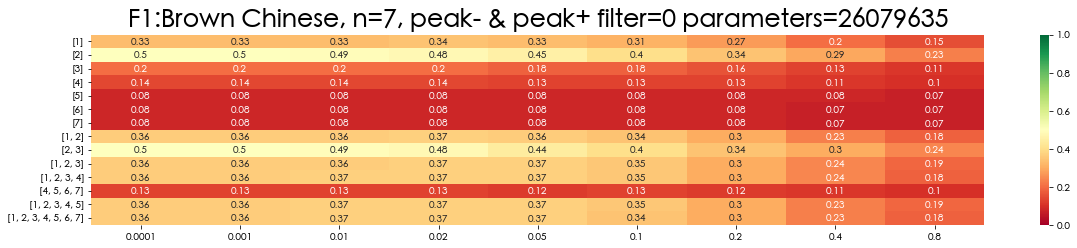

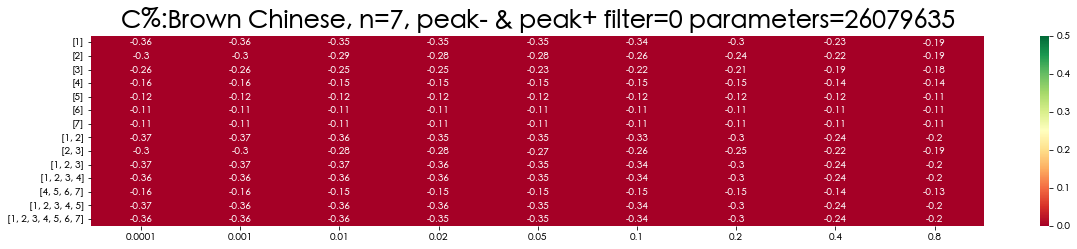

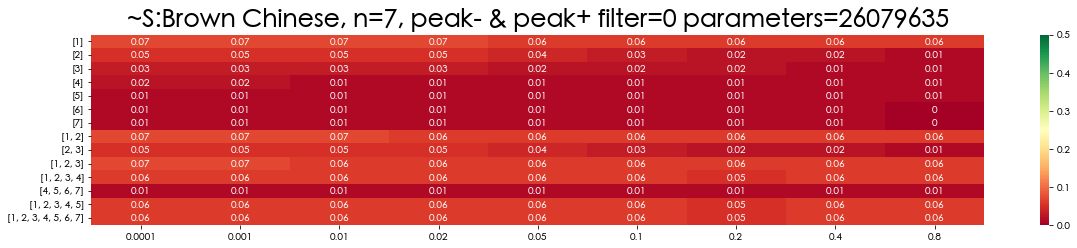

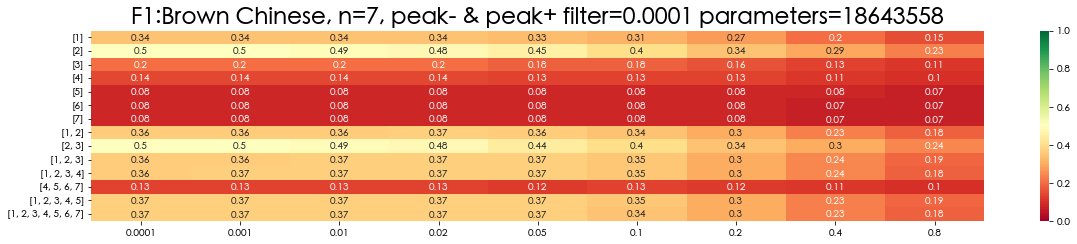

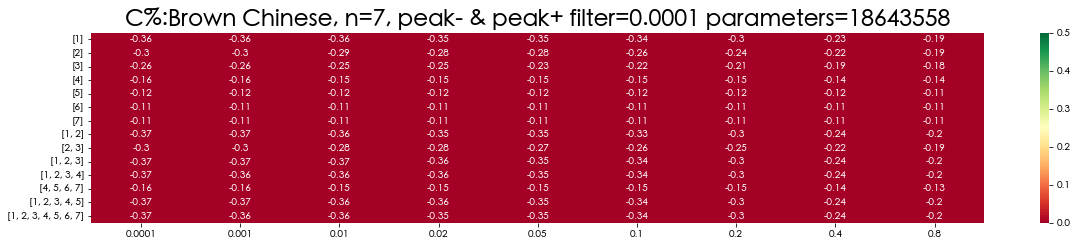

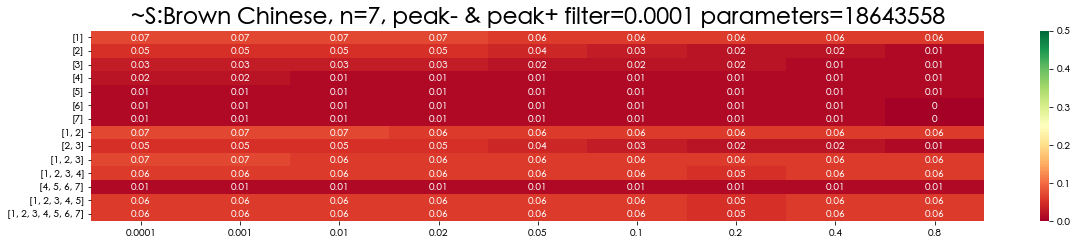

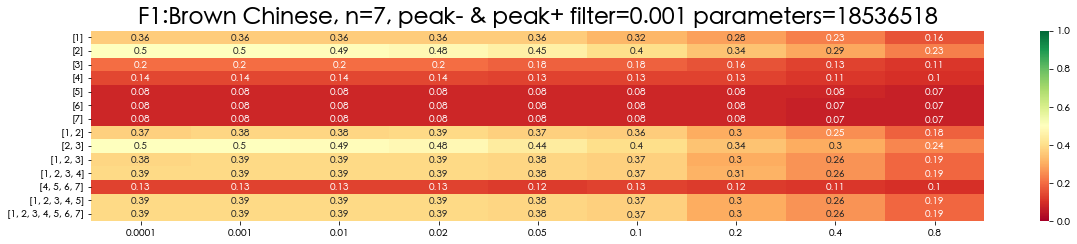

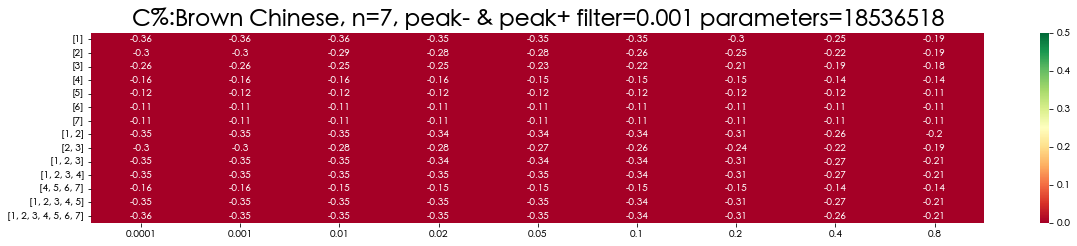

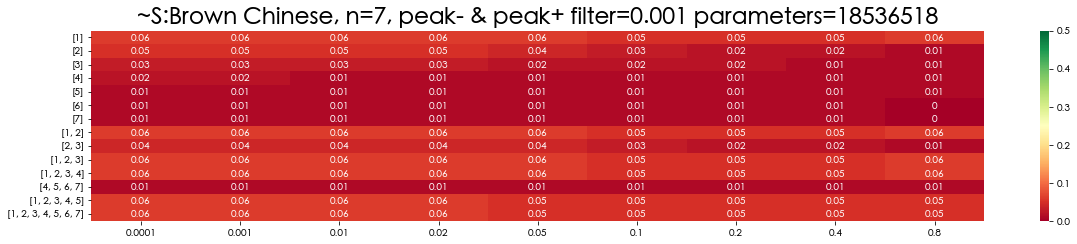

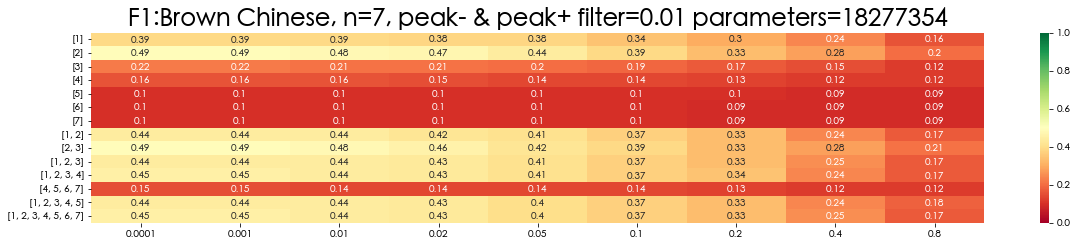

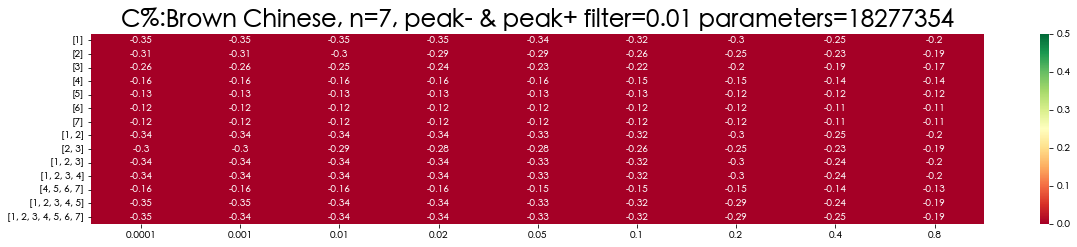

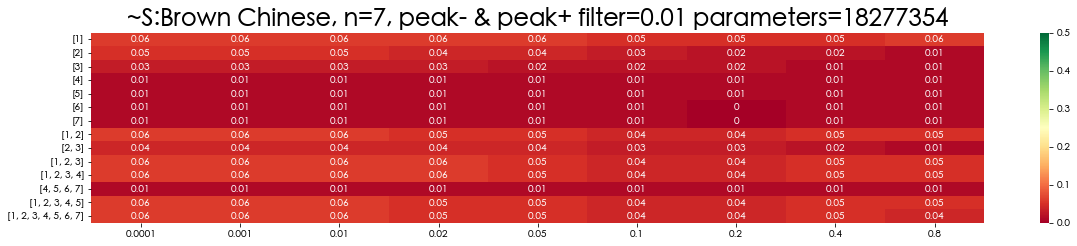

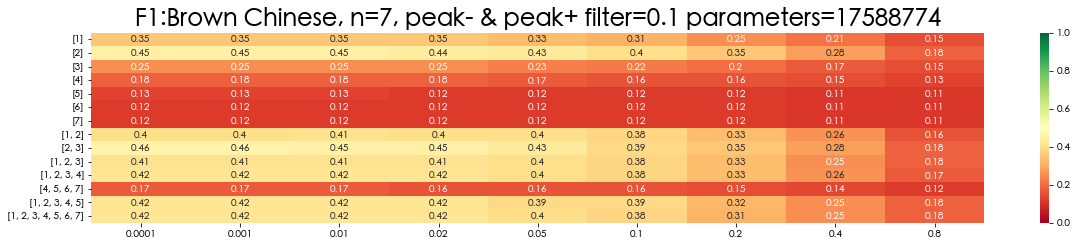

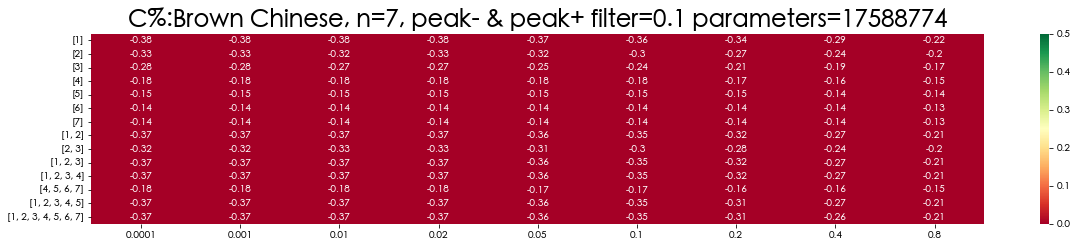

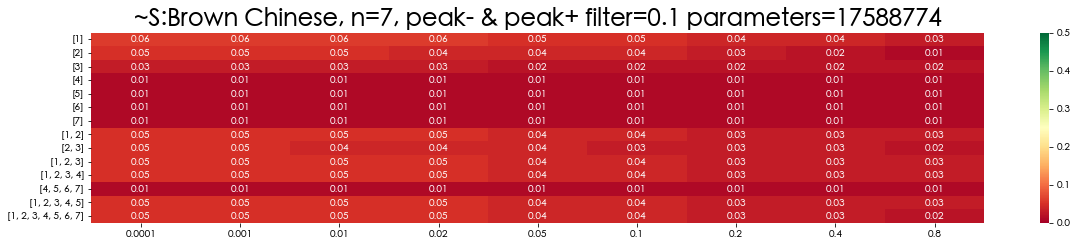

In [87]:
#token_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # en/ru
token_thresholds = [0.0001,0.001,0.01,0.02,0.05,0.1,0.2,0.4,0.8] # zh

base = FreedomTokenizer(name='data/models/brown_zh_chars_7',max_n=7,mode='chars',debug=False)
print(base.count_params())
title = 'Brown Chinese, n=7, peak- & peak+'
metric100_list_zh_peakt01 = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(test_zh,ref_tokenizer,FreedomBasedTokenizer(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={}".format(title,model_threshold,parameters))
    metric100_list_zh_peakt01.extend([(model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


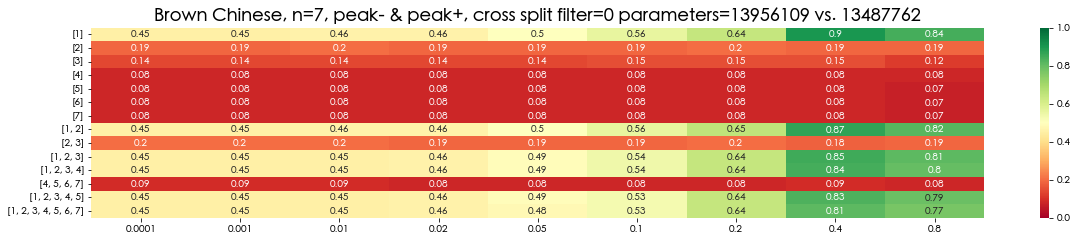

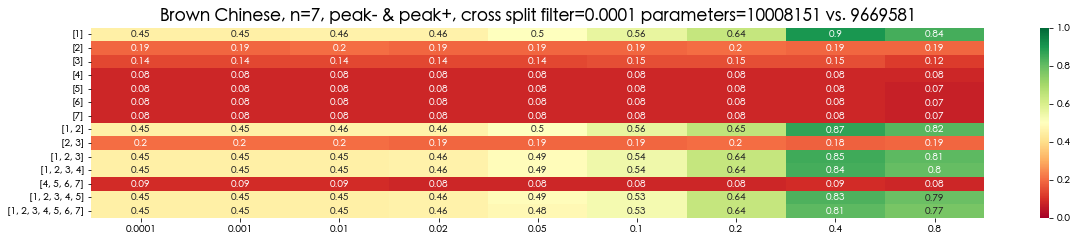

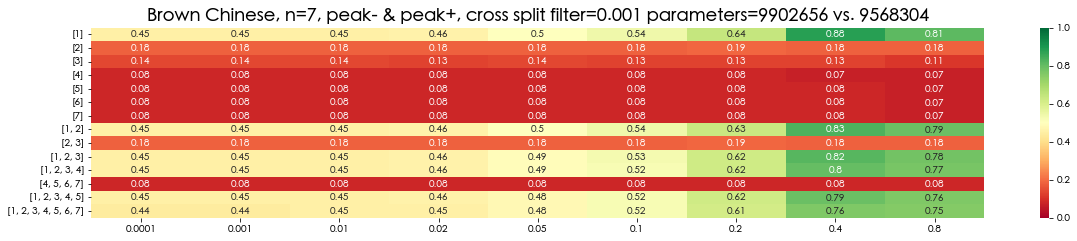

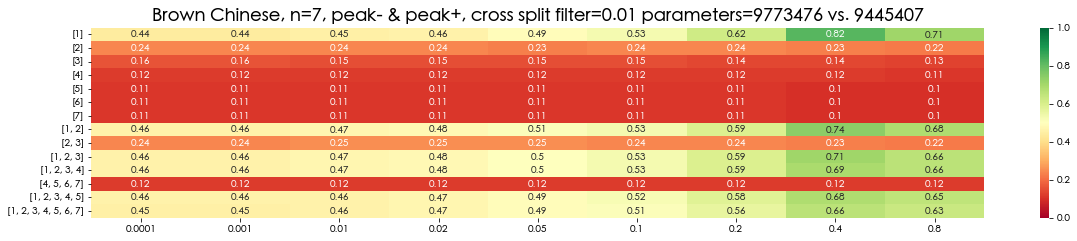

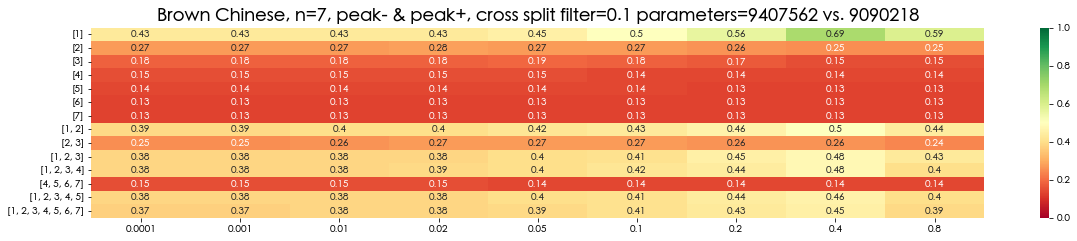

In [90]:
#token_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # en/ru
token_thresholds = [0.0001,0.001,0.01,0.02,0.05,0.1,0.2,0.4,0.8] # zh

base1 = FreedomTokenizer(name='data/models/brown_zh_chars_7_test1',max_n=7,mode='chars',debug=False)
base2 = FreedomTokenizer(name='data/models/brown_zh_chars_7_test2',max_n=7,mode='chars',debug=False)
title = 'Brown Chinese, n=7, peak- & peak+, cross split'
cross100_f_list_zh_peakt01 = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base1.model,model_threshold)
        model_compress_with_loss(base2.model,model_threshold)
    parameters1 = base1.count_params()
    parameters2 = base2.count_params()
    metrics = evaluate_freedom_tokenizer_options(test_zh,
        FreedomBasedTokenizer(base1,'peak-','peak+'),
        FreedomBasedTokenizer(base2,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={} vs. {}".format(title,model_threshold,parameters1,parameters2))
    cross100_f_list_zh_peakt01.extend([(model_threshold,m[0],m[1],m[2]) for m in metrics])
del base1
del base2


In [93]:
m_df, top_df = summarise_metrics(metric100_list_zh_peakt01,cross100_f_list_zh_peakt01)
top_df


CSF1 X ~S 0.8268452894524327
CSF1 X C% -0.6330030276425422
~S X C% -0.8829322510408202


,metric,F1,corr
63,~S,0.36,0.79
7,CSF1+~S,0.20,0.51
7,CSF1*~S,0.20,0.51
7,CSF1,0.20,0.48
7,CSF1+~S+C%,0.20,0.20
7,CSF1+C%,0.20,0.12
429,CSF1*~S*C%,0.09,-0.62
429,C%*~S,0.09,-0.83
430,C%+~S,0.09,-0.91
430,C%,0.09,-0.91


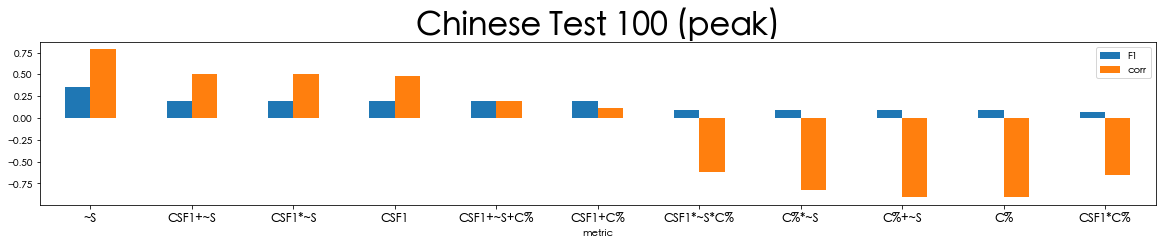

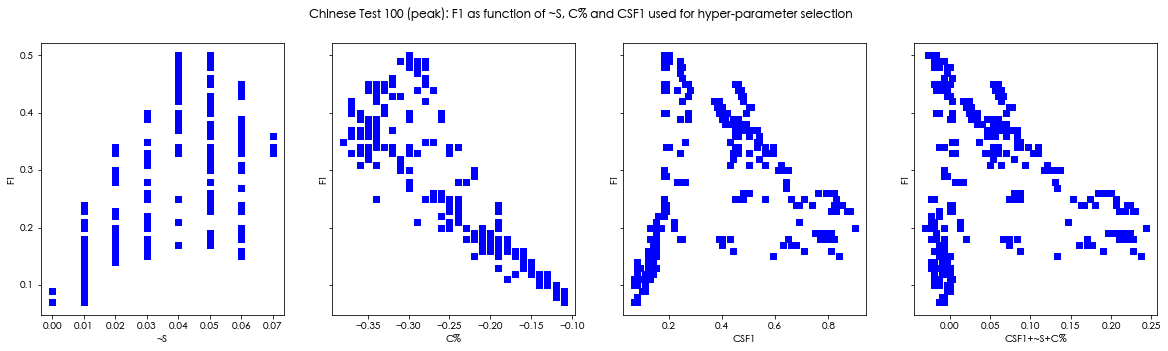

In [94]:
plot_multi_bars(m_df, top_df, 'Chinese Test 100 (peak) - sighan2005/as_test_gold')


## Test on 1000 

In [100]:
texts = [l.replace(" ", "") for l in lines if len(l) > 0][:1000]
truths = [l.split() for l in lines if len(l) > 0][:1000]

test_zh = texts
print(len(test_zh))
test_zh[:10]


1000


['许多社区长青学苑多开设有书法、插花、土风舞班，',
 '文山区长青学苑则有个十分特别的“英文歌唱班”，',
 '成员年龄均超过六十岁，',
 '这群白发苍苍，',
 '爷爷、奶奶级的学员唱起英文歌来字正腔圆，',
 '有模有样。',
 '对他们来说，',
 '能与一群志同道合的朋友共同回味年少时期流行的歌曲，',
 '才是参加英文歌唱班最大乐趣。',
 '长青学苑英文歌唱班昨日在社教馆举行“英文怀念金曲演唱会”，']

In [101]:
ref_tokenizer = dic_tokenizer

model_thresholds = [0,0.0001,0.001,0.01,0.1]
ngram_params = [[1],[2],[3],[4],[5],[6],[7],[1,2],[2,3],[1,2,3],[1,2,3,4],[4,5,6,7],[1,2,3,4,5],[1,2,3,4,5,6,7]]


26079635


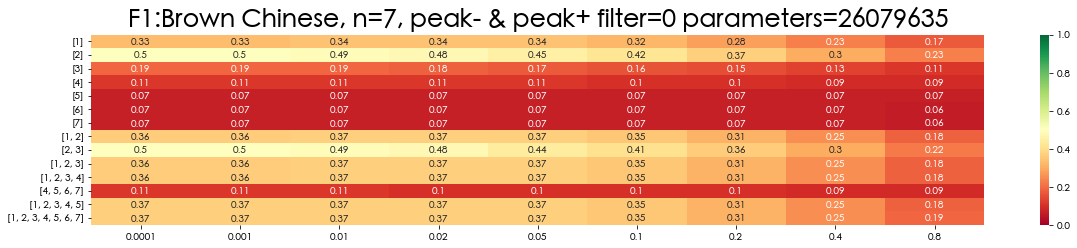

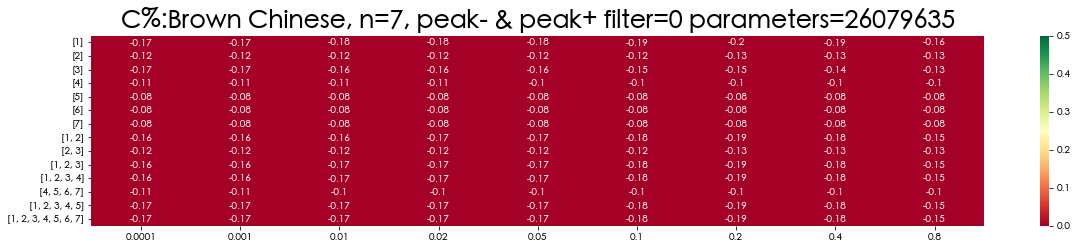

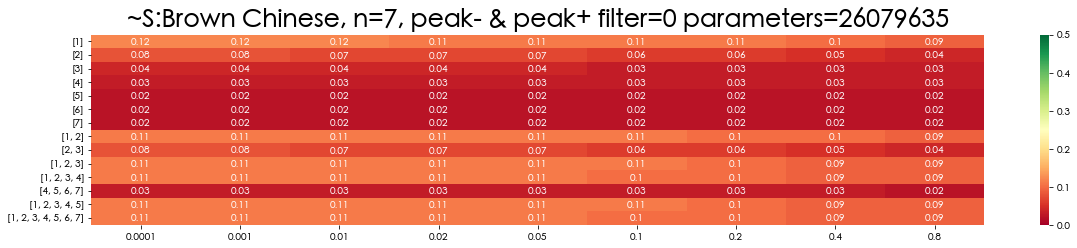

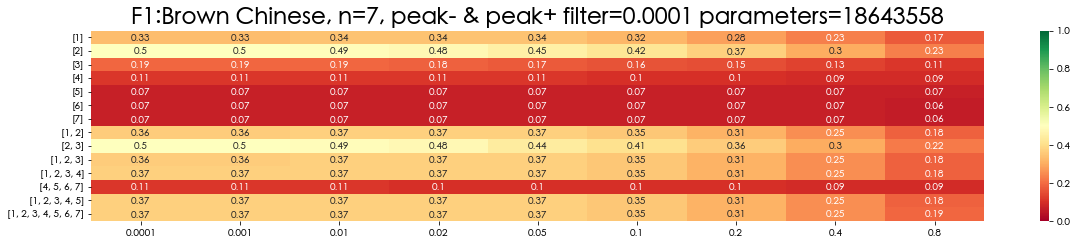

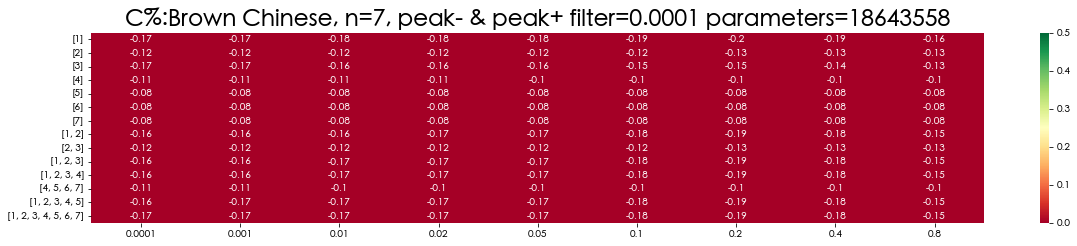

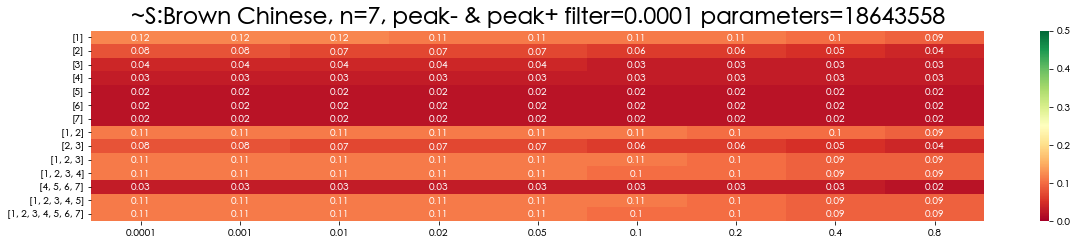

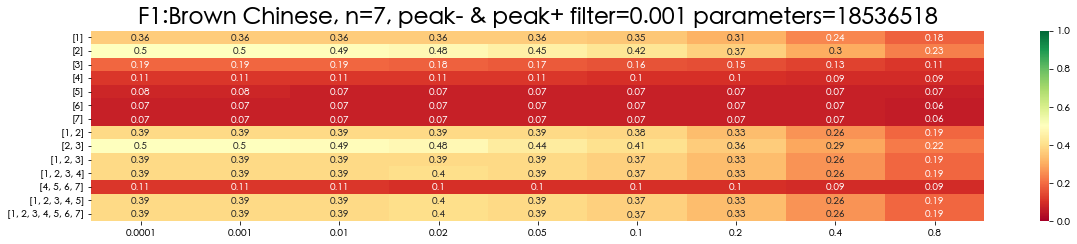

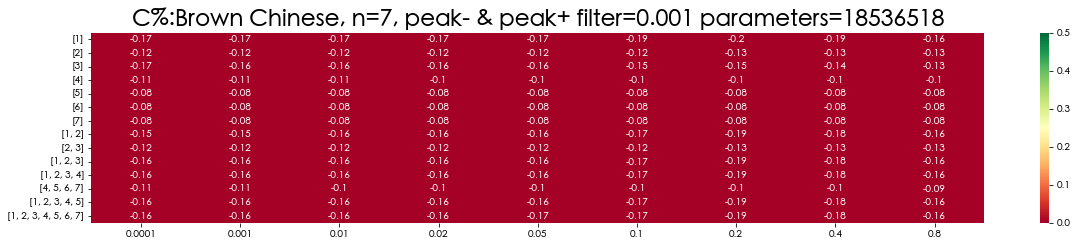

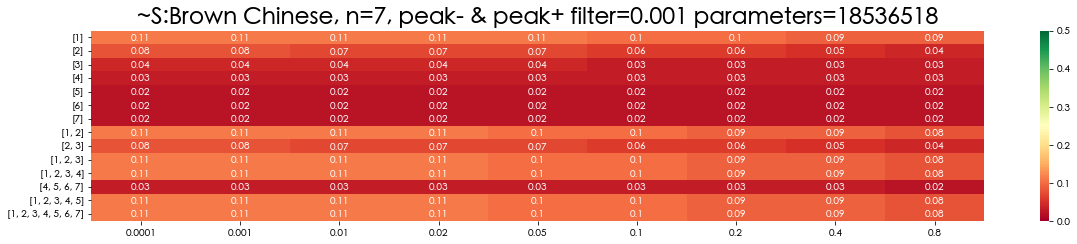

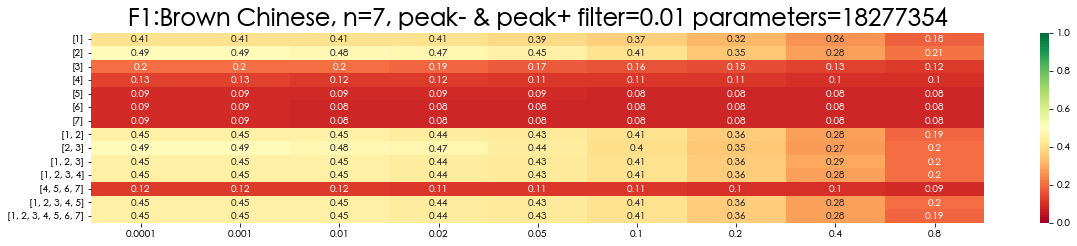

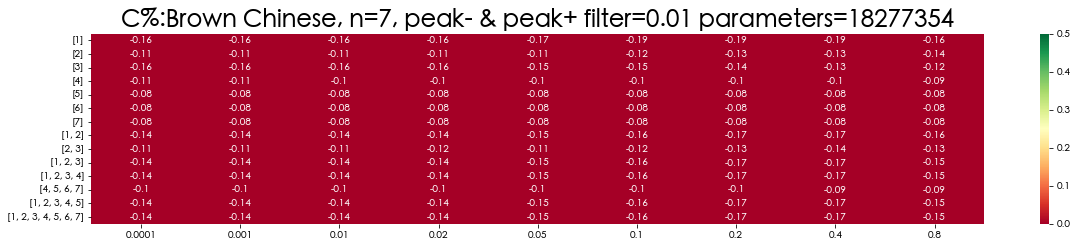

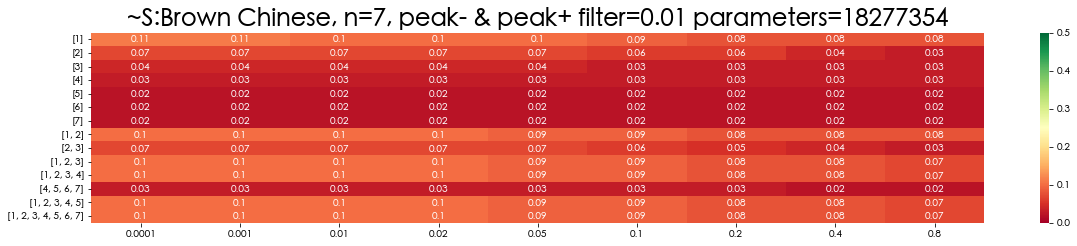

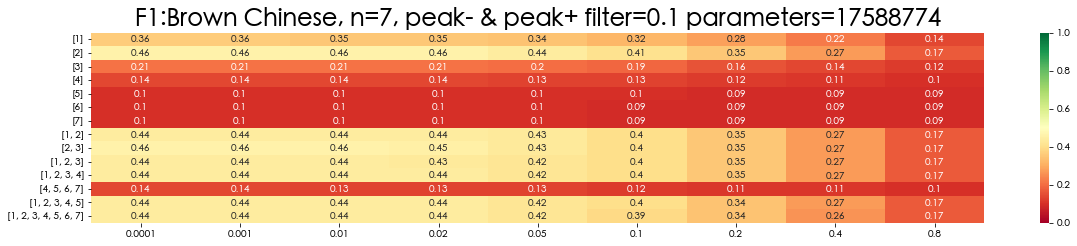

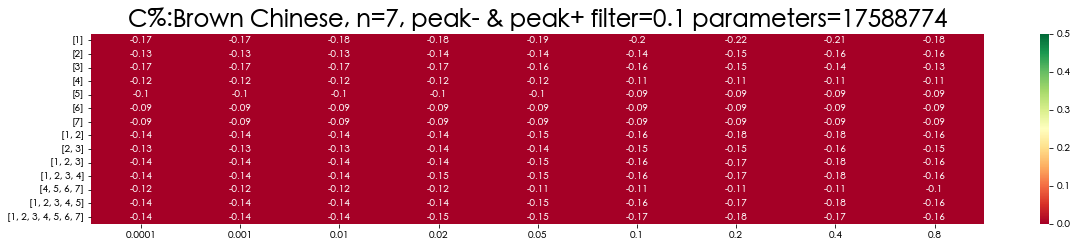

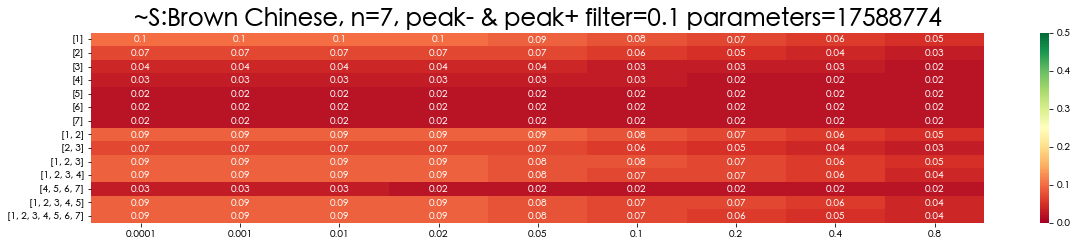

In [102]:
#token_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # en/ru
token_thresholds = [0.0001,0.001,0.01,0.02,0.05,0.1,0.2,0.4,0.8] # zh

base = FreedomTokenizer(name='data/models/brown_zh_chars_7',max_n=7,mode='chars',debug=False)
print(base.count_params())
title = 'Brown Chinese, n=7, peak- & peak+'
metric1000_list_zh_peakt01 = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(test_zh,ref_tokenizer,FreedomBasedTokenizer(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={}".format(title,model_threshold,parameters))
    metric1000_list_zh_peakt01.extend([(model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


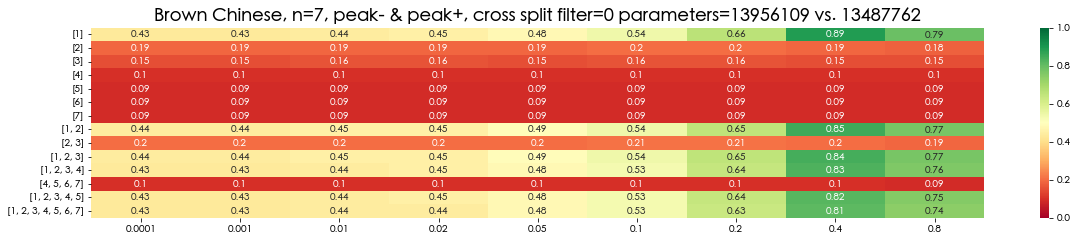

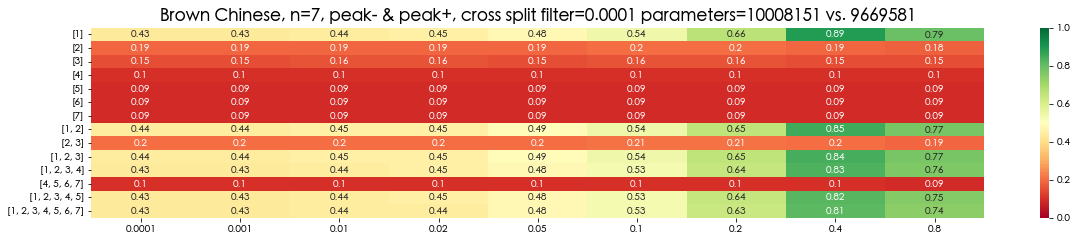

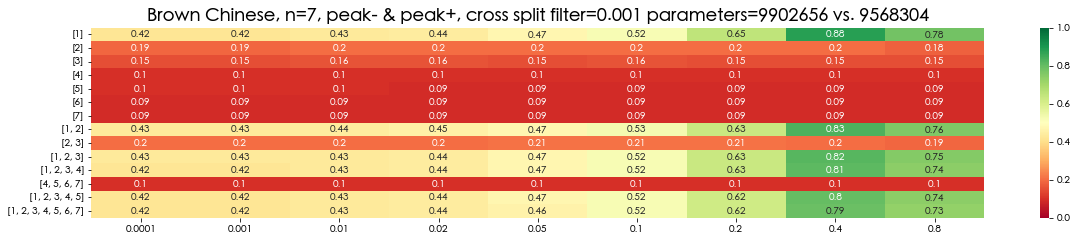

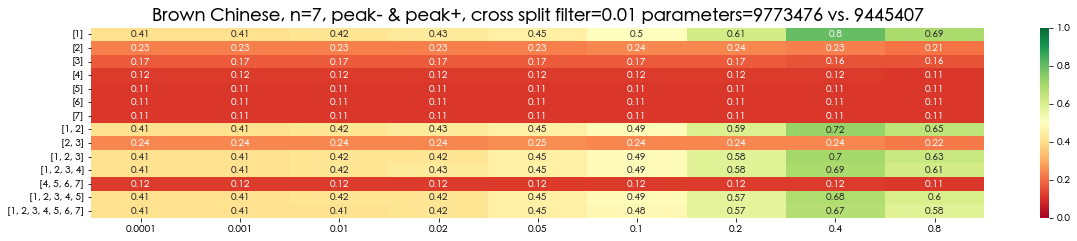

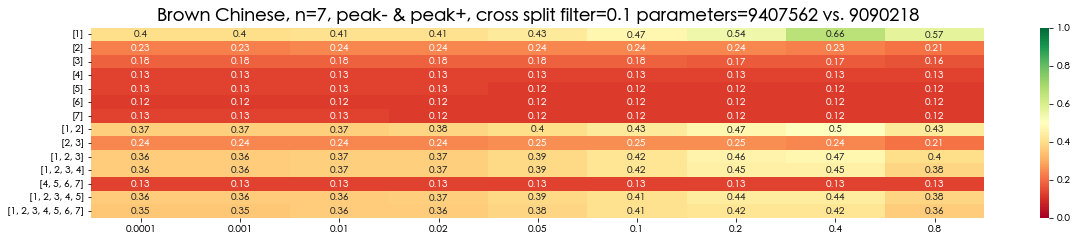

In [103]:
#token_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # en/ru
token_thresholds = [0.0001,0.001,0.01,0.02,0.05,0.1,0.2,0.4,0.8] # zh

base1 = FreedomTokenizer(name='data/models/brown_zh_chars_7_test1',max_n=7,mode='chars',debug=False)
base2 = FreedomTokenizer(name='data/models/brown_zh_chars_7_test2',max_n=7,mode='chars',debug=False)
title = 'Brown Chinese, n=7, peak- & peak+, cross split'
cross1000_f_list_zh_peakt01 = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base1.model,model_threshold)
        model_compress_with_loss(base2.model,model_threshold)
    parameters1 = base1.count_params()
    parameters2 = base2.count_params()
    metrics = evaluate_freedom_tokenizer_options(test_zh,
        FreedomBasedTokenizer(base1,'peak-','peak+'),
        FreedomBasedTokenizer(base2,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={} vs. {}".format(title,model_threshold,parameters1,parameters2))
    cross1000_f_list_zh_peakt01.extend([(model_threshold,m[0],m[1],m[2]) for m in metrics])
del base1
del base2

In [104]:
m_df, top_df = summarise_metrics(metric1000_list_zh_peakt01,cross1000_f_list_zh_peakt01)
top_df

CSF1 X ~S 0.8079571987879379
CSF1 X C% -0.8223111085671129
~S X C% -0.8084468676710668


,metric,F1,corr
9,C%+~S,0.50,0.30
2,~S,0.34,0.83
7,CSF1*~S,0.23,0.57
7,CSF1+~S,0.23,0.56
7,CSF1+~S+C%,0.23,0.54
7,CSF1,0.23,0.50
7,CSF1+C%,0.23,0.46
414,C%,0.09,-0.62
414,C%*~S,0.09,-0.74
36,CSF1*C%,0.07,-0.47


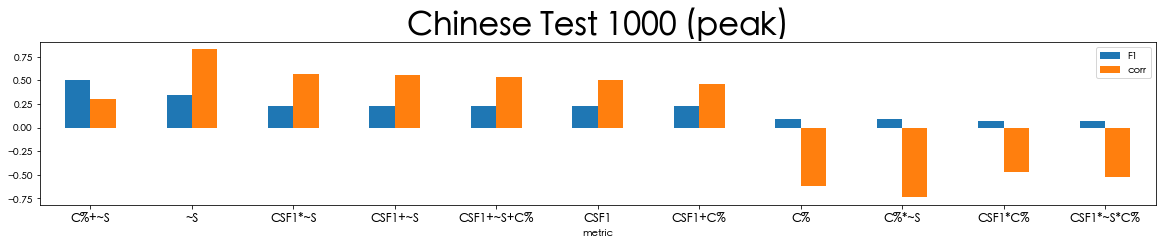

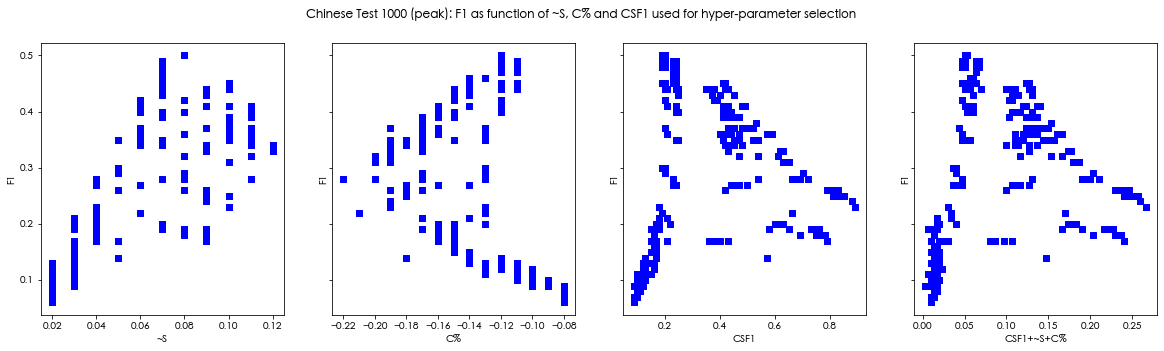

In [105]:
plot_multi_bars(m_df, top_df, 'Chinese Test 1000 (peak) - sighan2005/as_test_gold')


## Test on 10000

In [106]:
texts = [l.replace(" ", "") for l in lines if len(l) > 0][:10000]
truths = [l.split() for l in lines if len(l) > 0][:10000]

test_zh = texts
print(len(test_zh))
test_zh[:10]


10000


['许多社区长青学苑多开设有书法、插花、土风舞班，',
 '文山区长青学苑则有个十分特别的“英文歌唱班”，',
 '成员年龄均超过六十岁，',
 '这群白发苍苍，',
 '爷爷、奶奶级的学员唱起英文歌来字正腔圆，',
 '有模有样。',
 '对他们来说，',
 '能与一群志同道合的朋友共同回味年少时期流行的歌曲，',
 '才是参加英文歌唱班最大乐趣。',
 '长青学苑英文歌唱班昨日在社教馆举行“英文怀念金曲演唱会”，']

In [107]:
ref_tokenizer = dic_tokenizer

model_thresholds = [0,0.0001,0.001,0.01,0.1]
ngram_params = [[1],[2],[3],[4],[5],[6],[7],[1,2],[2,3],[1,2,3],[1,2,3,4],[4,5,6,7],[1,2,3,4,5],[1,2,3,4,5,6,7]]


26079635


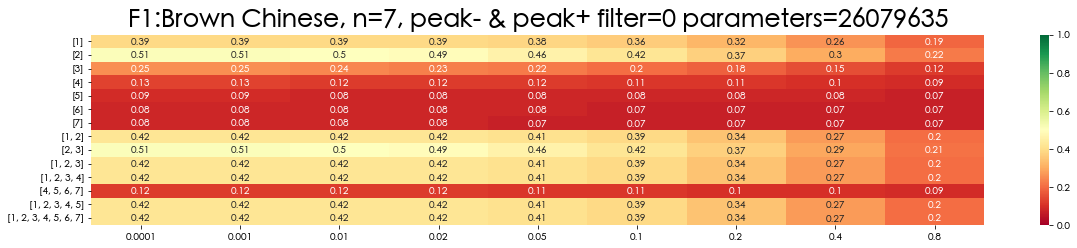

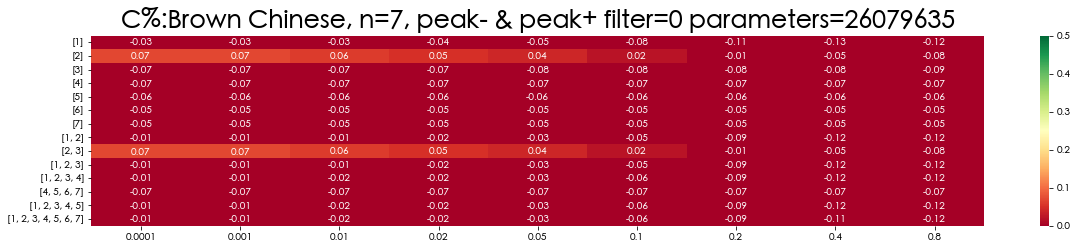

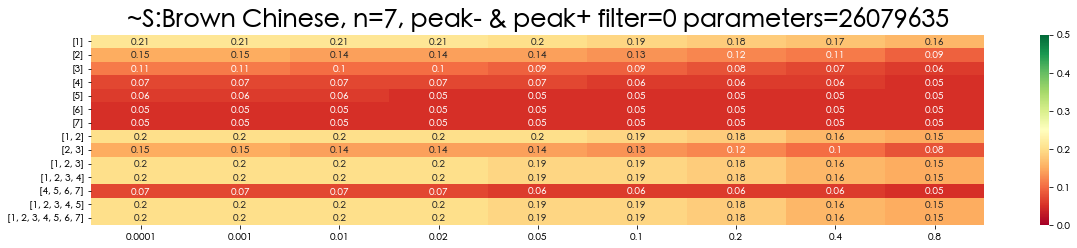

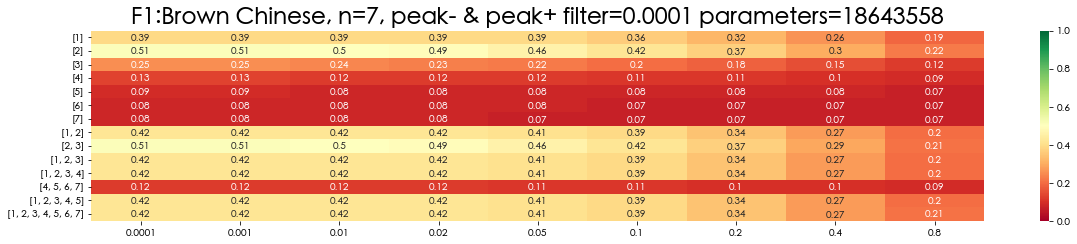

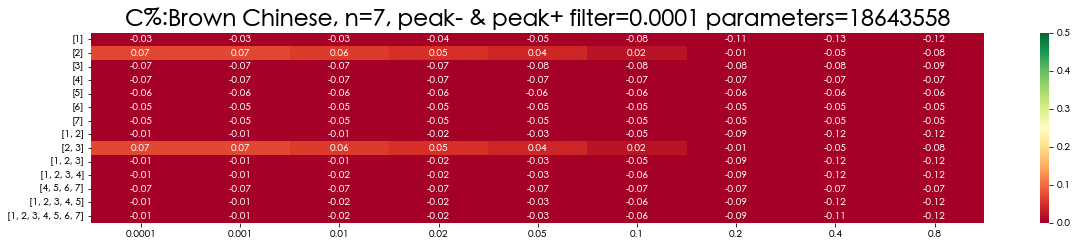

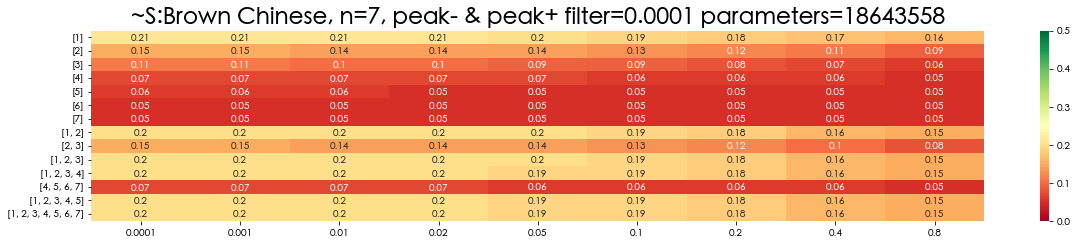

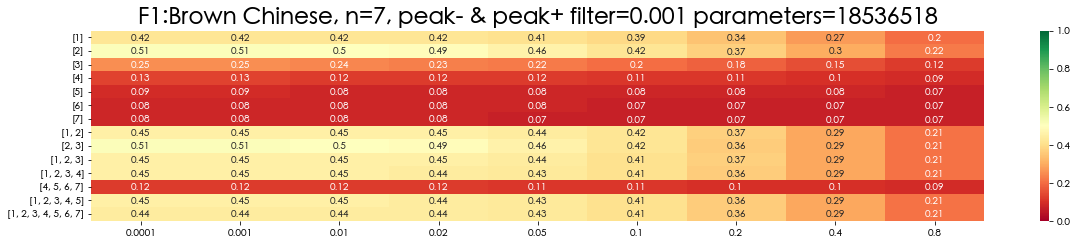

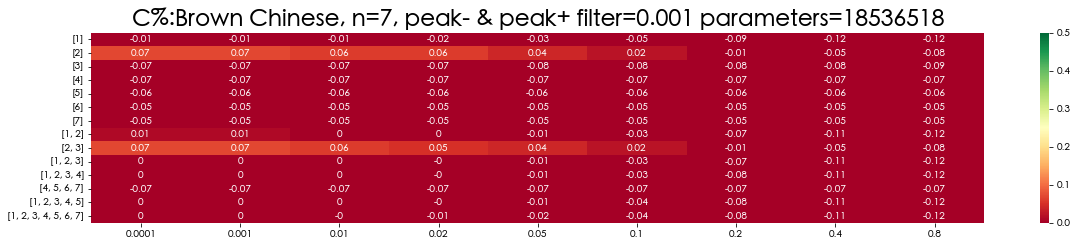

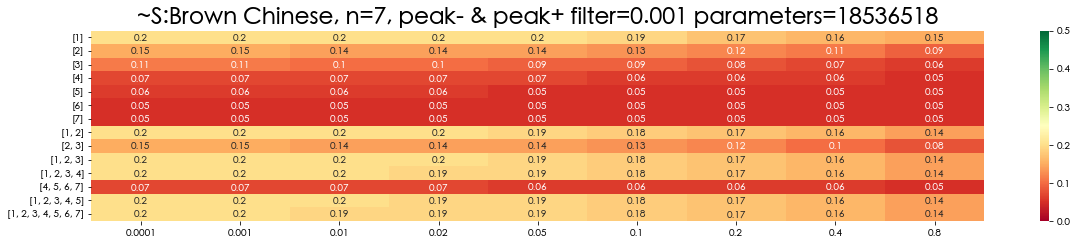

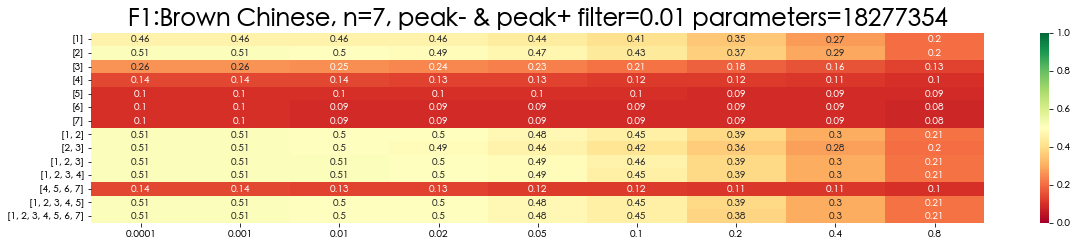

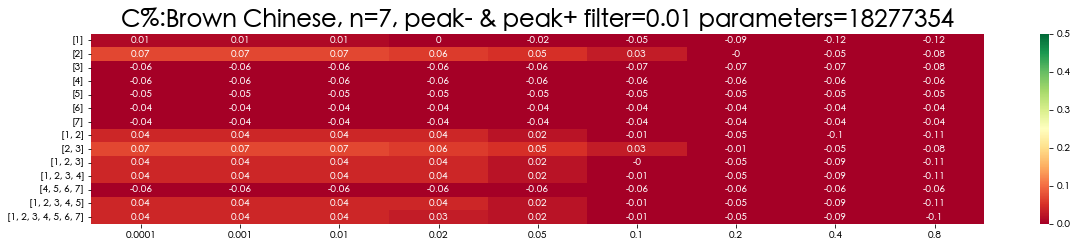

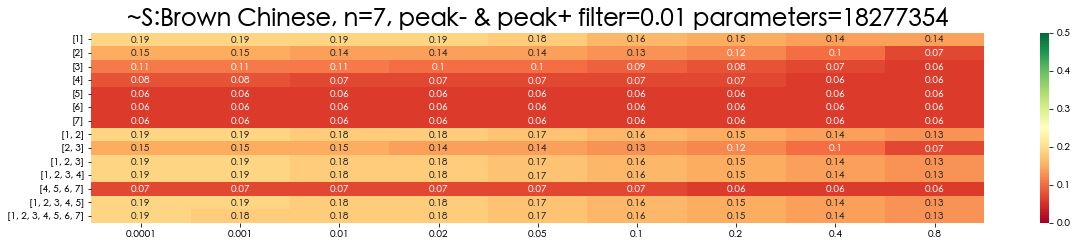

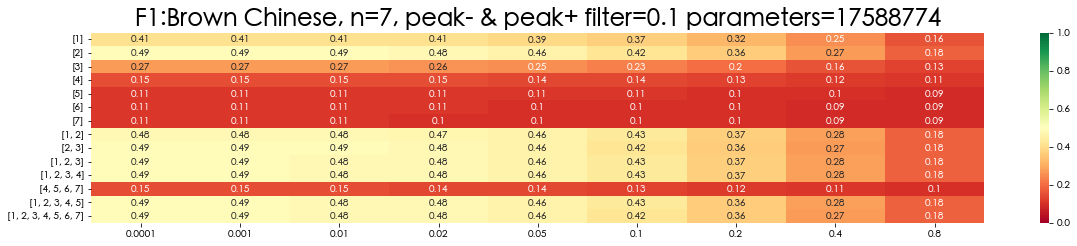

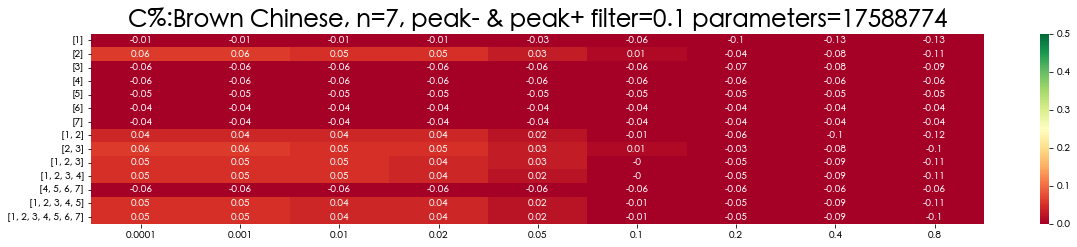

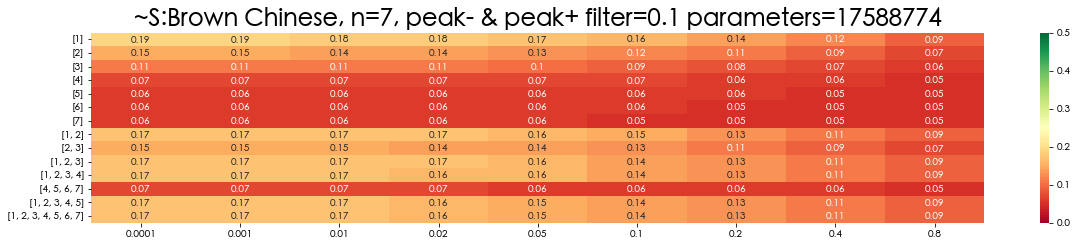

In [108]:
#token_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # en/ru
token_thresholds = [0.0001,0.001,0.01,0.02,0.05,0.1,0.2,0.4,0.8] # zh

base = FreedomTokenizer(name='data/models/brown_zh_chars_7',max_n=7,mode='chars',debug=False)
print(base.count_params())
title = 'Brown Chinese, n=7, peak- & peak+'
metric10000_list_zh_peakt01 = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base.model,model_threshold)
    parameters = base.count_params()
    metrics = evaluate_freedom_tokenizer_multimetrics(test_zh,ref_tokenizer,FreedomBasedTokenizer(base,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={}".format(title,model_threshold,parameters))
    metric10000_list_zh_peakt01.extend([(model_threshold,m[0],m[1],m[2],m[3],m[4]) for m in metrics])
del base


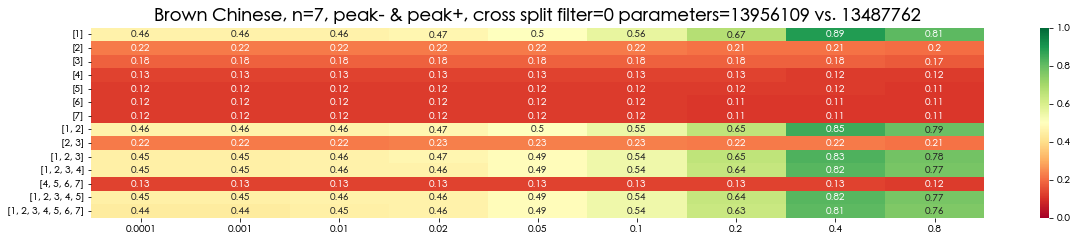

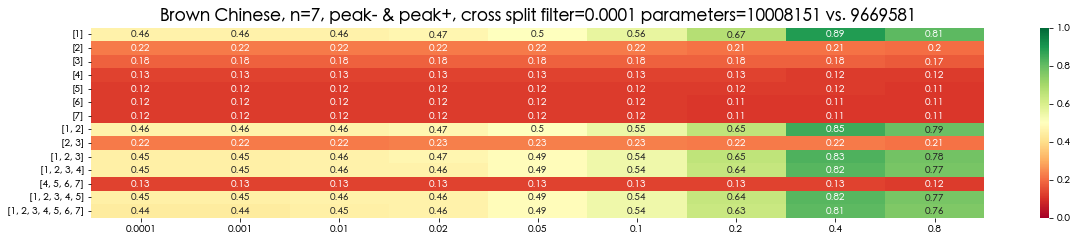

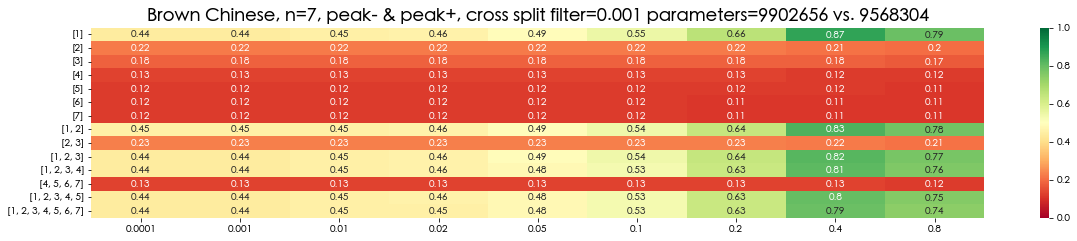

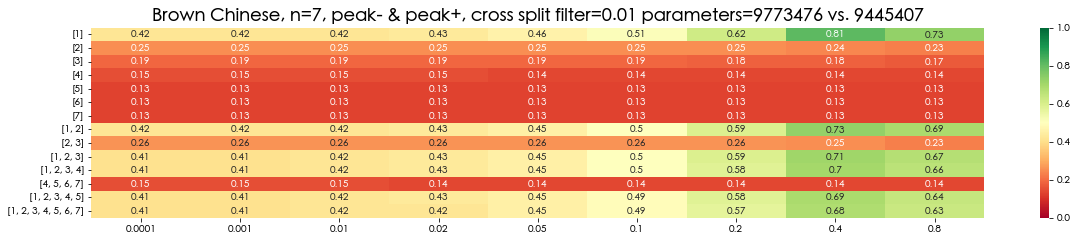

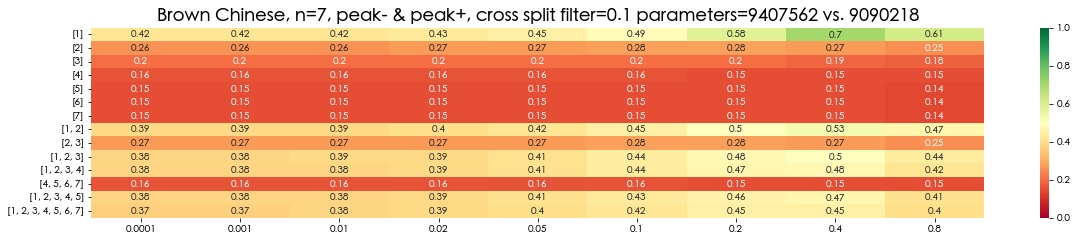

In [109]:
#token_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] # en/ru
token_thresholds = [0.0001,0.001,0.01,0.02,0.05,0.1,0.2,0.4,0.8] # zh

base1 = FreedomTokenizer(name='data/models/brown_zh_chars_7_test1',max_n=7,mode='chars',debug=False)
base2 = FreedomTokenizer(name='data/models/brown_zh_chars_7_test2',max_n=7,mode='chars',debug=False)
title = 'Brown Chinese, n=7, peak- & peak+, cross split'
cross10000_f_list_zh_peakt01 = []
for model_threshold in model_thresholds:
    if model_threshold > 0:
        model_compress_with_loss(base1.model,model_threshold)
        model_compress_with_loss(base2.model,model_threshold)
    parameters1 = base1.count_params()
    parameters2 = base2.count_params()
    metrics = evaluate_freedom_tokenizer_options(test_zh,
        FreedomBasedTokenizer(base1,'peak-','peak+'),
        FreedomBasedTokenizer(base2,'peak-','peak+'),
        ngram_params,token_thresholds,title="{} filter={} parameters={} vs. {}".format(title,model_threshold,parameters1,parameters2))
    cross10000_f_list_zh_peakt01.extend([(model_threshold,m[0],m[1],m[2]) for m in metrics])
del base1
del base2


In [110]:
m_df, top_df = summarise_metrics(metric10000_list_zh_peakt01,cross10000_f_list_zh_peakt01)
top_df


CSF1 X ~S 0.7632551295108712
CSF1 X C% -0.16117426363083648
~S X C% 0.3934060289668331


,metric,F1,corr
441,C%+~S,0.51,0.95
9,C%,0.51,0.69
9,C%*~S,0.51,0.39
587,CSF1*C%,0.48,0.22
587,CSF1*~S*C%,0.48,0.12
0,~S,0.39,0.89
7,CSF1+~S+C%,0.26,0.75
7,CSF1+C%,0.26,0.69
7,CSF1*~S,0.26,0.64
7,CSF1+~S,0.26,0.62


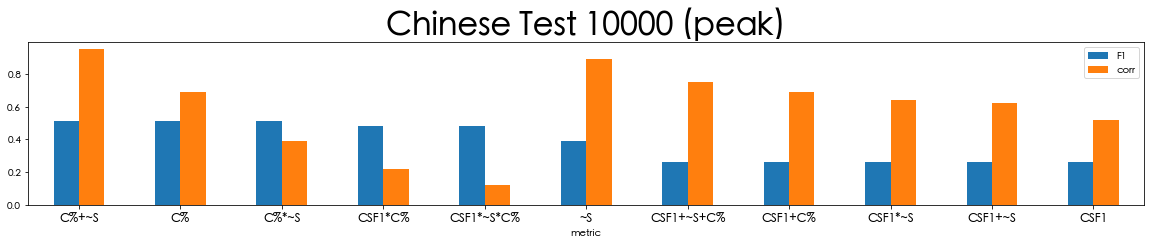

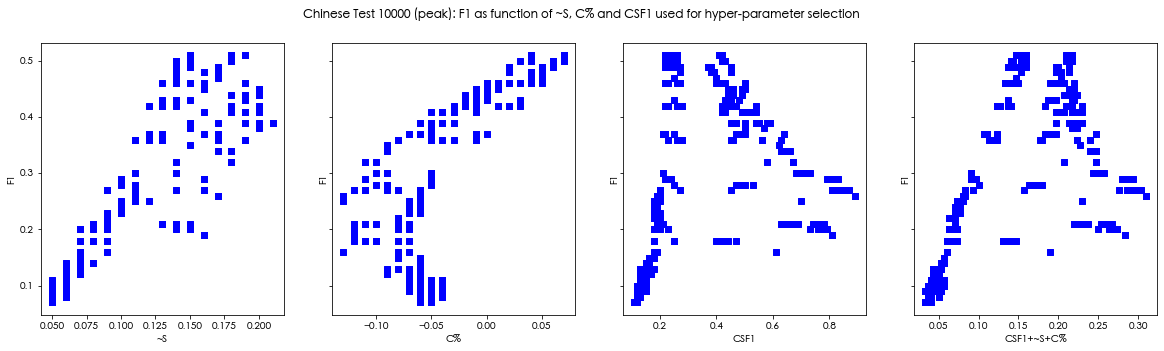

In [111]:
plot_multi_bars(m_df, top_df, 'Chinese Test 10000 (peak) - sighan2005/as_test_gold')
